In [16]:
import os
import cv2
import torch 
import numpy as np
import onnxruntime as ort

from models import Unet

from preprocessing import (
    subsample_point_cloud, 
    create_digital_elevation_model,
    pad_multiplo,
    create_input)

from postprocessing import(
    get_binary_img,
    get_componets,
    get_segments,
    get_measurement,
    get_coords
)

class PretilNet:
    def __init__(self, weights="model.pth", device='cuda'):
        self.model = Unet().cuda()
        self.model.load_state_dict(torch.load(weights))
        self.device = device


    def __call__(self, las_file, factor_size=0.1):
        ## Preprocessing
        dem_info = self.__preprocessing(las_file, factor_size)
        input = create_input(dem_info['dem']).astype(np.float32)
        input = torch.tensor(input, dtype=torch.float32, device=self.device)
        
        ## IA
        outputs = self.model(input)  # Returns a list of tensors.
    
        ## Posprocessing
        data_pixel = self.__postprocessing(outputs, dem_info['mask'])
        results = get_coords(data_pixel, dem_info)
        return results
    
    def __preprocessing(self, input_file, factor_size):
        las = subsample_point_cloud(input_file, factor=factor_size)
        dem_info = create_digital_elevation_model(las.x,las.y,las.z) # cambiar ahora es un dict dem_info
        dem_info['dem'], dem_info['mask'] = pad_multiplo(dem_info['dem'], dem_info['mask'])
        return dem_info

    def __postprocessing(self, outputs, mask):
        mask = np.expand_dims(mask, -1)
        outputs = [o.detach().cpu().numpy() for o in outputs]
        outputs = [o[0,:,:,:].transpose(1, 2, 0) * mask for o in outputs]
        
        img_class = outputs[0]
        img_pretil = outputs[1]

        binary_img = get_binary_img(img_class)
        valid_components, labels = get_componets(binary_img)
        segments = get_segments(valid_components, labels)
        binary_mask = binary_img.astype(bool)
        results = get_measurement(segments, binary_mask, img_pretil)

        return results


In [ ]:
import numpy as np

# Initialize the PretilNet model
model = PretilNet(weights="weigths/model_epoch_80.pth")

path_las = '../data/reduced_Inspecciones_Aéreas_Cámara_L2_Lidar_1.las'

outputs = model(path_las, factor_size=1)
print(outputs)

(1984, 1472, 3) (1984, 1472, 1)


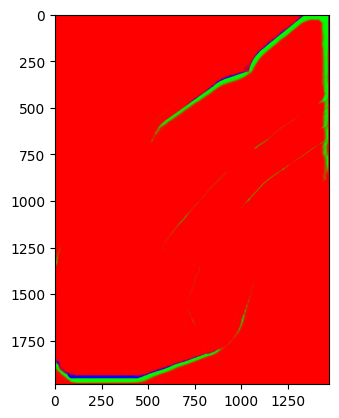

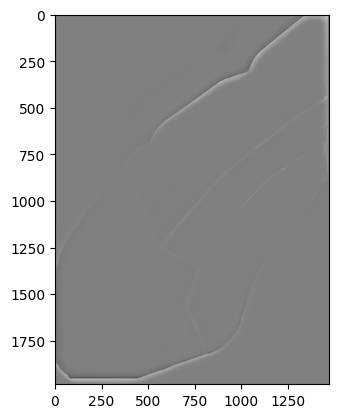

In [ ]:
# import matplotlib.pyplot as plt
# #mask = dem_info['mask']
# #mask = np.expand_dims(mask, -1)
# o = [o.detach().cpu().numpy()[0,:,:,:].transpose(1, 2, 0) for o in outputs]
        
# o1 = o[0] 
# o1 = (np.clip(o1,0,1)*255).astype(np.uint8)
# o2 = o[1]
# print(o1.shape, o2.shape)

# plt.imshow(o1) 
# plt.show()
# plt.imshow(o2, cmap='gray') 
# plt.show()